In [5]:
import pandas as pd
import numpy as np
import json
import os
import sys
from sklearn.metrics import f1_score
import h3pandas
import torch
import h3
from sklearn.metrics import precision_recall_curve
import argparse
from tqdm import tqdm

sys.path.append('../')
import datasets
import models
import utils
import setup

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [2]:
MODEL_PATH = "../pretrained_models/model_an_full_input_enc_sin_cos_hard_cap_num_per_class_1000.pt"
train_df_h3 = pd.read_csv("../pseudo_absence_generation_data/train_df_h3.csv", index_col=0)
gdfk = pd.read_csv("../pseudo_absence_generation_data/gdfk_res3.csv", index_col=0)
all_spatial_grid_counts = train_df_h3.index.value_counts()
presence_absence = pd.DataFrame({
    "background": all_spatial_grid_counts,
})
presence_absence = presence_absence.fillna(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_params = torch.load(MODEL_PATH, map_location='cpu')
model = models.get_model(train_params['params'])
model.load_state_dict(train_params['state_dict'], strict=True)
model = model.to(DEVICE)
model.eval()

ResidualFCNet(
  (class_emb): Linear(in_features=256, out_features=47375, bias=False)
  (feats): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=

In [3]:

if train_params['params']['input_enc'] in ['env', 'sin_cos_env']:
    raster = datasets.load_env()
else:
    raster = None
enc = utils.CoordEncoder(train_params['params']['input_enc'], raster=raster)

#load reference from iucn
with open(os.path.join('../data/eval/iucn/', 'iucn_res_5.json'), 'r') as f:
            data = json.load(f)
species_ids = list((data['taxa_presence'].keys()))

obs_locs = np.array(gdfk[['lng', 'lat']].values, dtype=np.float32)
obs_locs = torch.from_numpy(obs_locs).to('cpu')
loc_feat = enc.encode(obs_locs)

classes_of_interest = torch.zeros(len(species_ids), dtype=torch.int64)
for tt_id, tt in enumerate(species_ids):
    class_of_interest = np.array([train_params['params']['class_to_taxa'].index(int(tt))])
    classes_of_interest[tt_id] = torch.from_numpy(class_of_interest)

with torch.no_grad():
    loc_emb = model(loc_feat, return_feats=True)
    wt = model.class_emb.weight[classes_of_interest, :]


In [7]:
size_factor = 1
output = []
for class_index, class_id in tqdm(enumerate(classes_of_interest), total=len(classes_of_interest)):
    wt_1 = wt[class_index,:]
    preds = torch.sigmoid(torch.matmul(loc_emb, wt_1)).cpu().numpy()

    x_comb=preds
    # fit mixture of gaussian with two gaussians 
    gm = GaussianMixture(n_components=2, random_state=0).fit(x_comb[..., np.newaxis])
    print('estimated means\n', np.round(gm.means_,3))

    # evaluate all locations in range [0, 1]
    x_test = np.linspace(0, 1, 10000)
    op = gm.predict_proba(x_test[..., np.newaxis])

    # get the threshold, i.e. the cross over point between two gaussians
    if gm.means_[0][0] > gm.means_[1][0]: threshold_id = np.where(op[:, 0] > op[:, 1])[0][0] 
    else: threshold_id = np.where(op[:, 0] < op[:, 1])[0][0]
    threshold = x_test[threshold_id]
    print('threshold:', np.round(threshold, 8))

    if class_index==20:break



  0%|          | 1/2418 [00:00<17:19,  2.32it/s]

estimated means
 [[0.   ]
 [0.158]]
threshold: 0.00470047


  0%|          | 2/2418 [00:00<13:35,  2.96it/s]

estimated means
 [[0.   ]
 [0.155]]
threshold: 0.00450045


  0%|          | 3/2418 [00:00<12:46,  3.15it/s]

estimated means
 [[0.  ]
 [0.06]]
threshold: 0.00440044


  0%|          | 4/2418 [00:01<11:24,  3.53it/s]

estimated means
 [[0.   ]
 [0.164]]
threshold: 0.00450045


  0%|          | 5/2418 [00:01<10:30,  3.83it/s]

estimated means
 [[0.   ]
 [0.169]]
threshold: 0.00470047


  0%|          | 6/2418 [00:01<10:35,  3.79it/s]

estimated means
 [[0.   ]
 [0.121]]
threshold: 0.00440044


  0%|          | 8/2418 [00:02<09:23,  4.27it/s]

estimated means
 [[0.   ]
 [0.261]]
threshold: 0.00480048
estimated means
 [[0.   ]
 [0.238]]
threshold: 0.0050005


  0%|          | 9/2418 [00:02<09:39,  4.15it/s]

estimated means
 [[0.   ]
 [0.328]]
threshold: 0.00460046


  0%|          | 10/2418 [00:02<11:45,  3.41it/s]

estimated means
 [[0.   ]
 [0.192]]
threshold: 0.00450045


  0%|          | 11/2418 [00:03<11:00,  3.64it/s]

estimated means
 [[0.   ]
 [0.327]]
threshold: 0.00480048


  0%|          | 12/2418 [00:03<10:25,  3.85it/s]

estimated means
 [[0.   ]
 [0.195]]
threshold: 0.00490049


  1%|          | 13/2418 [00:03<10:46,  3.72it/s]

estimated means
 [[0.   ]
 [0.166]]
threshold: 0.00450045


  1%|          | 14/2418 [00:03<10:37,  3.77it/s]

estimated means
 [[0.   ]
 [0.069]]
threshold: 0.00430043


  1%|          | 16/2418 [00:04<09:28,  4.23it/s]

estimated means
 [[0.  ]
 [0.22]]
threshold: 0.00460046
estimated means
 [[0.   ]
 [0.198]]
threshold: 0.0050005


  1%|          | 17/2418 [00:04<09:01,  4.43it/s]

estimated means
 [[0.   ]
 [0.124]]
threshold: 0.00490049


  1%|          | 18/2418 [00:04<09:09,  4.37it/s]

estimated means
 [[0.   ]
 [0.206]]
threshold: 0.00450045


  1%|          | 19/2418 [00:04<09:08,  4.37it/s]

estimated means
 [[0.   ]
 [0.137]]
threshold: 0.00450045


  1%|          | 20/2418 [00:05<09:07,  4.38it/s]

estimated means
 [[0.   ]
 [0.259]]
threshold: 0.00460046
estimated means
 [[0.   ]
 [0.153]]


  1%|          | 20/2418 [00:05<10:39,  3.75it/s]

threshold: 0.00520052


estimated means
 [[0.   ]
 [0.153]]
threshold: 0.00520052


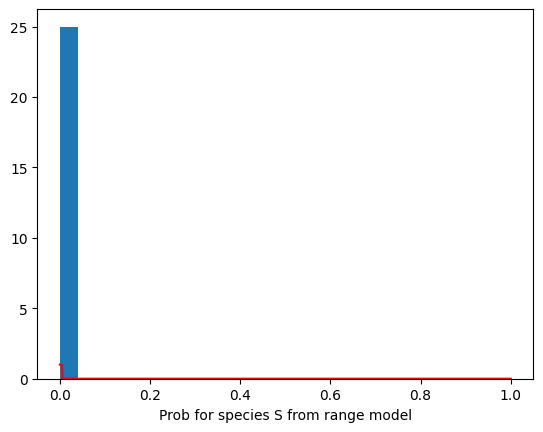

In [8]:


# create some dummy data that represents the outputs 
# here pretending the outputs of the range estimation model
# can be represented as two gaussians, one for each of 
# present or absent
"""cls1 = np.random.randn(100)*0.1 + 0.1
cls2 = np.random.randn(100)*0.1 + 0.7
x_comb = np.hstack((cls1, cls2))
x_comb = np.clip(x_comb, 0, 1)"""
x_comb=preds
# fit mixture of gaussian with two gaussians 
gm = GaussianMixture(n_components=2, random_state=0).fit(x_comb[..., np.newaxis])
print('estimated means\n', np.round(gm.means_,3))

# evaluate all locations in range [0, 1]
x_test = np.linspace(0, 1, 10000)
op = gm.predict_proba(x_test[..., np.newaxis])

# get the threshold, i.e. the cross over point between two gaussians
if gm.means_[0][0] > gm.means_[1][0]: threshold_id = np.where(op[:, 0] > op[:, 1])[0][0] 
else: threshold_id = np.where(op[:, 0] < op[:, 1])[0][0]
threshold = x_test[threshold_id]
print('threshold:', np.round(threshold, 8))

# plot 
plt.close('all')
plt.figure(1)
plt.hist(x_comb, 25, [0, 1], density=True)
plt.plot(x_test, op[:, 0], 'r')
#plt.plot(x_test, op[:, 1], 'b')
plt.xlabel('Prob for species S from range model')
plt.show()

estimated means
 [[0.704]
 [0.106]]
threshold: 0.366


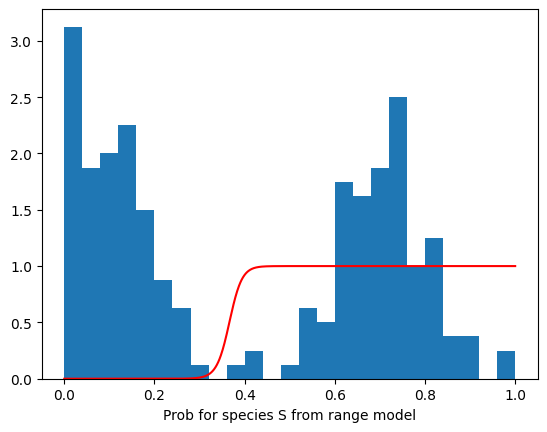

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# create some dummy data that represents the outputs 
# here pretending the outputs of the range estimation model
# can be represented as two gaussians, one for each of 
# present or absent
cls1 = np.random.randn(100)*0.1 + 0.1
cls2 = np.random.randn(100)*0.1 + 0.7
x_comb = np.hstack((cls1, cls2))
x_comb = np.clip(x_comb, 0, 1)

# fit mixture of gaussian with two gaussians 
gm = GaussianMixture(n_components=2, random_state=0).fit(x_comb[..., np.newaxis])
print('estimated means\n', np.round(gm.means_,3))

# evaluate all locations in range [0, 1]
x_test = np.linspace(0, 1, 1000)
op = gm.predict_proba(x_test[..., np.newaxis])

# get the threshold, i.e. the cross over point between two gaussians
if gm.means_[0][0] > gm.means_[1][0]: threshold_id = np.where(op[:, 0] > op[:, 1])[0][0] 
else: threshold_id = np.where(op[:, 0] < op[:, 1])[0][0]
threshold = x_test[threshold_id]
print('threshold:', np.round(threshold, 3))

# plot 
plt.close('all')
plt.figure(1)
plt.hist(x_comb, 25, [0, 1], density=True)
plt.plot(x_test, op[:, 0], 'r')
#plt.plot(x_test, op[:, 1], 'b')
plt.xlabel('Prob for species S from range model')
plt.show()